# Reproducing Villena-Gonzalez CDA Study (2020) - Ref... WHY?!

## Notes:
- Something doesn't work... changing the ref changes the signal in the plot, but not in the CDA...


In [2]:
import numpy as np
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

Processing: CS230419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/CS230419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 796671  =      0.000 ...   389.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
-------------------

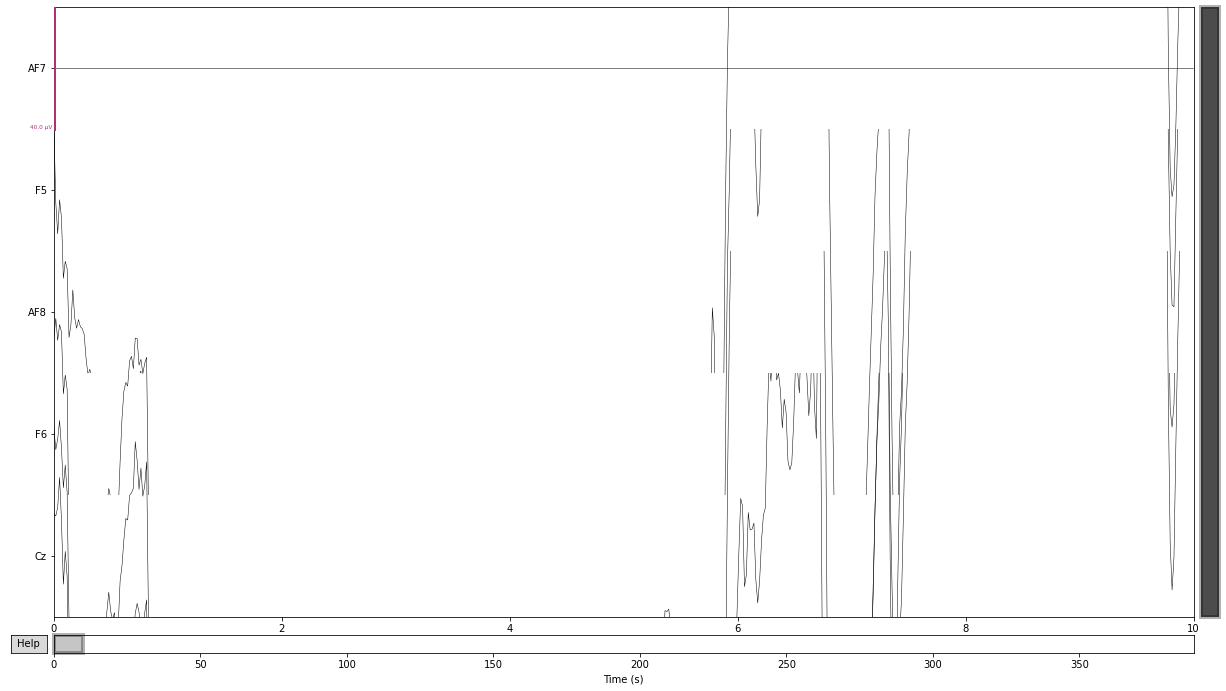

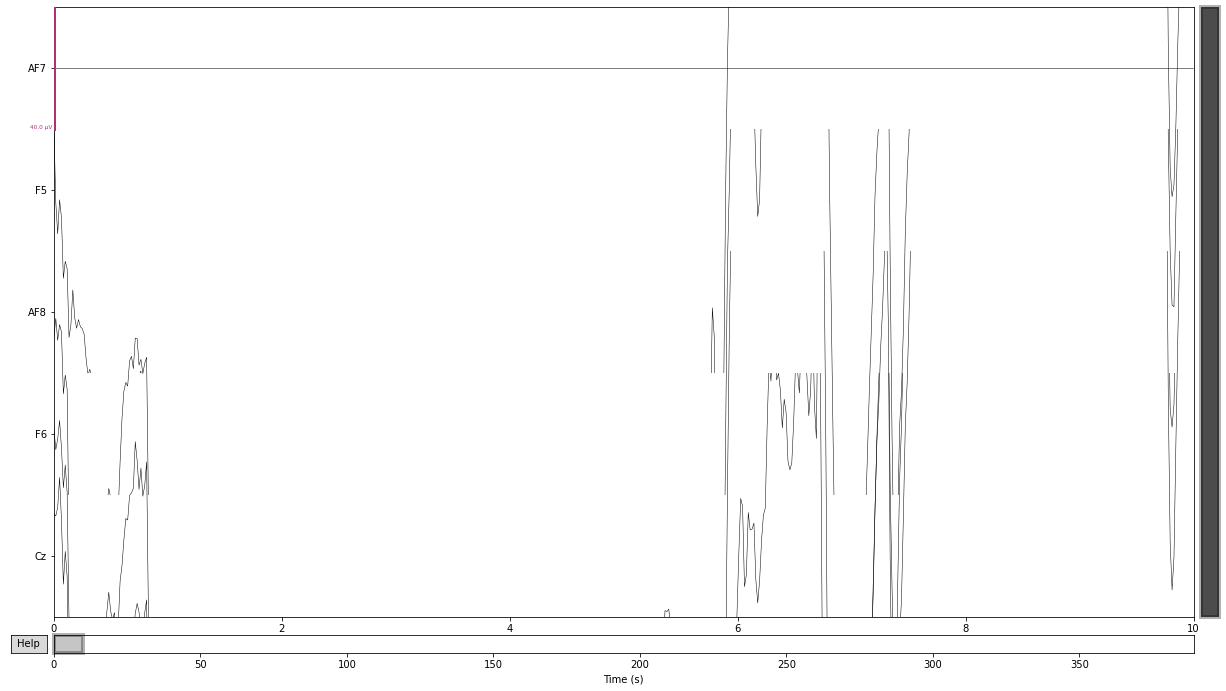

In [5]:
chan_refs = ['average', ['EXG7', 'EXG8'], ['AF8', 'AF7'], ['Cz']]

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

filepath = directory_path + 'CS230419.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind(sep)+1:]
print('Processing: ' + filename + '...')

# ------------------------
# 1. -- Load File --
# ------------------------
raw = read_raw_bdf(filepath, preload=True)

# ------------------------
# 2. -- Preprocessing --
# ------------------------
# Keep only EEG channels and reference
#raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
#raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG4','EXG5','EXG6'])
#raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
#raw = raw.set_channel_types({'EXG7': 'misc', 'EXG8': 'misc'})
preproc = raw.copy().set_eeg_reference(ref_channels=['AF7'])#['EXG1','EXG2'])

# Set Electrodes Locations
#montage = mne.channels.make_standard_montage('biosemi64')
#raw.set_montage(montage)

# Resample
preproc = preproc.resample(1024)

# Filter
preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

# Events
events = find_events(preproc)

# Plot (visual check)
preproc = preproc.pick_channels(['AF7', 'AF8', 'F5', 'F6', 'Cz'])
preproc.plot(events=events, block=True, lowpass=40)

In [18]:
#==================================================================
# General Variables
#==================================================================
## Organize Triggers
triggers = dict();

# --------------------------
triggers['1'] = [10,11,12,13] 
triggers['2'] = [20,21,22,23]
triggers['4'] = [40,41,42,43]

triggers['left'] = [11,12,21,22,41,42]
triggers['right'] = [10,13,20,23,40,43]

triggers['good'] = [60]
triggers['bad'] = [61]

# Labels
conds = ['1', '2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
chan_refs = ['average', ['EXG7', 'EXG8'], ['AF8', 'AF7'], ['Cz']]

# Epoch information
epoch_length = 2
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA main variable!
cda_dict = dict()
epochs_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

filepath = directory_path + 'CS230419.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind(sep)+1:]
print('Processing: ' + filename + '...')

cda_left = dict()
cda_right = dict()
cda = dict()

ref = ['EXG1', 'EXG2']
for ref in [['EXG1','EXG2'], ['EXG7', 'EXG8'], 'average', ['Cz'], ['AF8'], ['AF7', 'AF8']]: #chan_refs:
    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_bdf(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Keep only EEG channels and reference
    #raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
    #raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG4','EXG5','EXG6'])
    #raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
    #raw = raw.set_channel_types({'EXG7': 'misc', 'EXG8': 'misc'})

    preproc = raw.copy().set_eeg_reference(ref_channels=ref)

    # Set Electrodes Locations
    #montage = mne.channels.make_standard_montage('biosemi64')
    #raw.set_montage(montage)

    # Resample
    preproc = preproc.resample(1024)

    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = find_events(preproc)

    # Plot (visual check)
    #preproc.plot(events=events, block=True, lowpass=40)

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    #epochs_all[filename] = epochs_dict

    times = epochs_dict['2']['left']['good'].times

    #epochs_sub = epochs_dict['4']['left']['good'].copy().pick_channels(['AF7', 'AF8', 'Cz'])
    #evoked_subs = epochs_sub.average()
    
    epochs_right = epochs_dict['4']['left']['good'].copy().pick_channels(['AF8'])
    epochs_left = epochs_dict['4']['left']['good'].copy().pick_channels(['AF7'])

    evoked_right = epochs_right.average()
    evoked_left = epochs_left.average()

    left = evoked_left.data
    right = evoked_right.data

    cda_left[str(ref)] = left
    cda_right[str(ref)] = right
    
    #if cur_side == 'left':
    #cda = left - right
    
    #plt.plot(times, cda.mean(0), label=str(ref))
    #plt.legend()
    #plt.show() 

Processing: CS230419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/CS230419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 796671  =      0.000 ...   389.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
-------------------

0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 2254 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 2254 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/CS230419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 796671  =      0.000 ...   389.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value o

0 projection items activated
Loading data for 16 events and 2254 original time points ...
0 bad epochs dropped
---------- 2-right-bad -------------
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 2254 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 2254 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 2254 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
2 ma

0 projection items activated
Loading data for 16 events and 2254 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2254 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2254 original time points ...
0 bad epochs dropped
---------- 2-right-bad -------------
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 2254 original time points ...
0 bad epochs dropped
-------

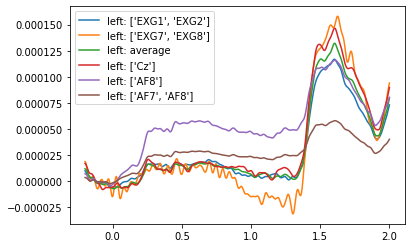

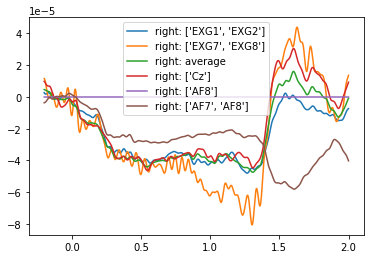

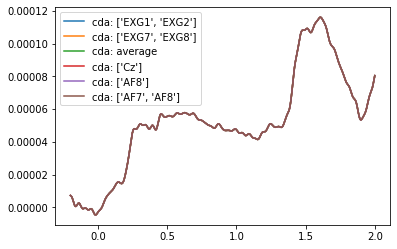

In [22]:
plt.figure()
for ref in cda_left.keys():
    plt.plot(times, cda_left[ref].mean(0), label='left: {}'.format(ref))
plt.legend()
plt.show() 

plt.figure()
for ref in cda_right.keys():
    plt.plot(times, cda_right[ref].mean(0), label='right: {}'.format(ref))
plt.legend()
plt.show() 

plt.figure()
for ref in cda_right.keys():
    plt.plot(times, (cda_left[ref] - cda_right[ref]).mean(0), label='cda: {}'.format(ref))
plt.legend()
plt.show() 

### Dipolar Referencing

In [ ]:
raw_bip_ref = mne.set_bipolar_reference(raw, anode=['EEG 054'],
                                        cathode=['EEG 055'])
raw_bip_ref.plot()

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO7-PO8


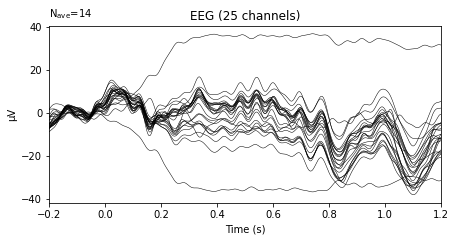

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7


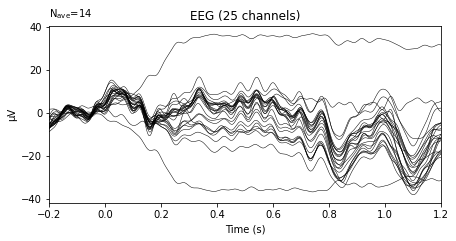

Need more than one channel to make topography for eeg. Disabling interactivity.


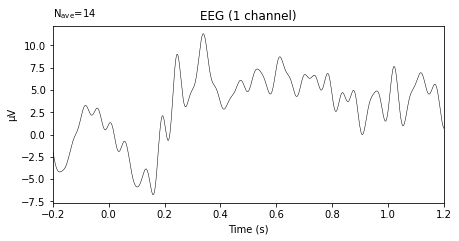

In [42]:
chan_right = ['AF7', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['AF8', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
chans_all = chan_right + chan_left

sub_epochs = epochs_dict['4']['right']['good'].copy().crop(tmin=-0.2, tmax=1.2).pick_channels(chans_all)

epochs_bi = mne.set_bipolar_reference(sub_epochs, anode=['PO7'], cathode=['PO8'])
evoked_bi = epochs_bi.average()
x = evoked_bi.plot()

epochs_bi = mne.set_bipolar_reference(sub_epochs, anode=['PO8'], cathode=['PO7'])
evoked_bi = epochs_bi.average()
x = evoked_bi.plot()

x = epochs_bi.pick_channels(['PO8-PO7']).average().plot()

In [ ]:
chan_right = ['AF7', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['AF8', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']
chans_all = chan_right + chan_left

sub_epochs = epochs_dict['4']['right']['good'].copy().crop(tmin=-0.2, tmax=1.2).pick_channels(chans_all)

epochs_bi = mne.set_bipolar_reference(sub_epochs, anode=['PO7'], cathode=['PO8'])
evoked_bi = epochs_bi.average()
x = evoked_bi.plot()

epochs_bi = mne.set_bipolar_reference(sub_epochs, anode=['PO8'], cathode=['PO7'])
evoked_bi = epochs_bi.average()
x = evoked_bi.plot()

x = epochs_bi.pick_channels(['PO8-PO7']).average().plot()